In [1]:
! tree -d ../data/enwiki

../data/enwiki
├── categorylinks
├── categorypages
├── page_parquet
├── pagecount_daily_v1
├── pagecount_daily_v2
├── pagelinks
└── pages

7 directories


In [6]:
base = "../data/enwiki"
pages = spark.read.parquet(f"{base}/pages")
pagelinks = spark.read.parquet(f"{base}/pagelinks")
pagecounts = spark.read.parquet(f"{base}/pagecount_daily_v2")

pages.createOrReplaceTempView("pages")
pagelinks.createOrReplaceTempView("pagelinks")
pagecounts.createOrReplaceTempView("pagecount")

pages.show(n=5)
pagelinks.show(n=5)
pagecounts.show(n=5)

+---+---------+-----------+------+
| id|    title|is_redirect|is_new|
+---+---------+-----------+------+
| 12|Anarchism|      false| false|
| 25|   Autism|      false| false|
| 39|   Albedo|      false| false|
|290|        A|      false| false|
|303|  Alabama|      false| false|
+---+---------+-----------+------+
only showing top 5 rows

+--------+--------+
|    from|    dest|
+--------+--------+
|38319581|38315934|
|38320620|12010815|
|38320620|20038415|
|38320620|   45127|
|38320620|   48361|
+--------+--------+
only showing top 5 rows

+-------+----------+-----+
|page_id|      date|count|
+-------+----------+-----+
|1524604|2018-03-19|  425|
|1524604|2019-07-15|  173|
|1524604|2019-08-12|  182|
|1536068|2018-04-21|  144|
|1536068|2018-09-28|  167|
+-------+----------+-----+
only showing top 5 rows



# Inducing a connected graph

In [18]:
def sample_page() -> int:
    random_page = pages.sample(False, 0.001).limit(1).collect()[0]
    return random_page.id

spark.sql(f"select * from pages where id = {sample_page()}").show()

+----+-------+-----------+------+
|  id|  title|is_redirect|is_new|
+----+-------+-----------+------+
|4497|Bugatti|      false| false|
+----+-------+-----------+------+



In [38]:
from graphframes import GraphFrame
from pyspark.sql import functions as F

def neighborhood_k1(pages, pagelinks, seed: int) -> GraphFrame:
    g = GraphFrame(pages, pagelinks.selectExpr("from as src", "dest as dst"))
    paths = g.find("(a)-[e]->(b)").where(f"a.id == {seed}")
    return GraphFrame(g.vertices, paths.select("e.*")).dropIsolatedVertices()
    
def neighborhood_k2(pages, pagelinks, seed: int) -> GraphFrame:
    g = GraphFrame(pages, pagelinks.selectExpr("from as src", "dest as dst"))
    paths = g.find("(a)-[e1]->(b); (b)-[e2]->(c)").where(f"a.id == {seed}")
    edges = paths.select("e1.*").union(paths.select("e2.*"))
    return GraphFrame(g.vertices, edges).dropIsolatedVertices()


# 1000 nodes may be too sparsely connected for this to work out well
def induce_graph(pages, pagelinks, n: int = 1000) -> GraphFrame:
    sample = [n.id for n in pages.sample(False, 0.001).limit(n).collect()]
    g =  GraphFrame(
        pages,
        pagelinks.selectExpr("from as src", "dest as dst")
    ).filterVertices(F.col("id").isin(sample)).dropIsolatedVertices()
    return g

In [20]:
random_page = sample_page()
g = neighborhood_k2(pages, pagelinks, random_page)
g.vertices.count(), g.edges.count()

(27408, 124338)

In [39]:
g2 = neighborhood_k1(pages, pagelinks, random_page)
g2.vertices.count(), g2.edges.count()

(247, 246)

# Formatting the data correctly

In [41]:
g2.cache()
g2.vertices.show()

+--------+--------------------+-----------+------+
|      id|               title|is_redirect|is_new|
+--------+--------------------+-----------+------+
|  203794|         Alma_Mahler|      false| false|
|  351761|       Walter_Piston|      false| false|
|   65174|       Gustav_Mahler|      false| false|
|  140802|         Opus_number|      false| false|
|  590055|   Alberto_Ginastera|      false| false|
| 1995253|      René_Leibowitz|      false| false|
|  246830|      Elliott_Carter|      false| false|
| 4402111|Schliesse_mir_die...|      false| false|
|   40258|             Harmony|      false| false|
|   13066|     George_Gershwin|      false| false|
|  132809|        Leoš_Janáček|      false| false|
| 2275775|    Surrealist_music|      false| false|
|  143098|    Conlon_Nancarrow|      false| false|
|  373399|National_Diet_Lib...|      false| false|
| 4764461|         World_War_I|      false| false|
|   19556|        Mode_(music)|      false| false|
|34838010|       Manon_Gropius|

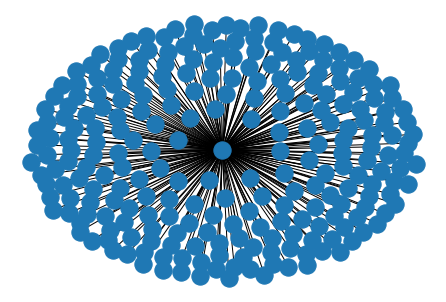

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

g2_nx = nx.from_pandas_edgelist(g2.edges.toPandas(), source="src", target="dst")
nx.draw(g2_nx)

In [47]:
pv = pagecounts.join(g2.vertices, on=g2.vertices.id == pagecounts.page_id, how="right")
pv.count()

57066

In [48]:
pv.show()

+--------+----------+-----+--------+--------------------+-----------+------+
| page_id|      date|count|      id|               title|is_redirect|is_new|
+--------+----------+-----+--------+--------------------+-----------+------+
|10522749|2018-03-15|  265|10522749|International_Mus...|      false| false|
|10522749|2018-07-09|  164|10522749|International_Mus...|      false| false|
|10522749|2018-09-18|  213|10522749|International_Mus...|      false| false|
|10522749|2018-12-17|  214|10522749|International_Mus...|      false| false|
|10522749|2018-04-04|  218|10522749|International_Mus...|      false| false|
|10522749|2018-02-19|  247|10522749|International_Mus...|      false| false|
|10522749|2018-03-25|  183|10522749|International_Mus...|      false| false|
|10522749|2018-04-11|  232|10522749|International_Mus...|      false| false|
|10522749|2018-09-15|  147|10522749|International_Mus...|      false| false|
|10522749|2018-11-08|  212|10522749|International_Mus...|      false| false|

In [55]:
pv.select("date").distinct().count()

609

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x133450860>]],
      dtype=object)

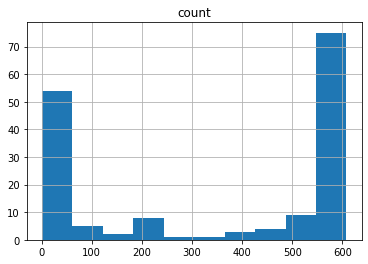

In [58]:
df = pv.where("date is not null").groupBy("page_id").count().toPandas()
df.hist("count")

In [61]:
df = (
    pv.
    join(
        pv
        .groupBy("page_id")
        .agg(F.countDistinct("date").alias("age"))
        .where("age > 500"), on="page_id", how="right"
    )
    .where("date is not null")
    .groupBy("page_id")
    .pivot("date")
    .agg(F.min("count"))
).toPandas()

df

,page_id,2018-01-01,2018-01-02,2018-01-03,2018-01-04,2018-01-05,2018-01-06,2018-01-07,2018-01-08,2018-01-09,...,2019-08-23,2019-08-24,2019-08-25,2019-08-26,2019-08-27,2019-08-28,2019-08-29,2019-08-30,2019-08-31,2019-09-01
0,10522749,165.0,209.0,279,236,222.0,217.0,204.0,353,265.0,...,148.0,126.0,116.0,139.0,175.0,164.0,169.0,178.0,150.0,157.0
1,51097,167.0,191.0,206,190,185.0,187.0,159.0,260,241.0,...,144.0,109.0,137.0,159.0,164.0,150.0,158.0,132.0,154.0,135.0
2,224463,107.0,120.0,124,157,111.0,131.0,119.0,126,114.0,...,NaN,NaN,NaN,138.0,121.0,139.0,113.0,120.0,113.0,113.0
3,27681,400.0,489.0,534,534,477.0,467.0,476.0,610,687.0,...,350.0,296.0,319.0,417.0,399.0,409.0,377.0,625.0,342.0,314.0
4,1339871,NaN,157.0,175,185,171.0,192.0,194.0,210,179.0,...,179.0,149.0,187.0,146.0,163.0,189.0,262.0,234.0,290.0,240.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,64437,248.0,328.0,345,293,336.0,293.0,298.0,403,373.0,...,216.0,205.0,204.0,248.0,272.0,269.0,267.0,239.0,218.0,199.0
78,203794,NaN,NaN,107,101,NaN,NaN,NaN,106,NaN,...,107.0,NaN,NaN,134.0,103.0,113.0,117.0,140.0,2035.0,202.0
79,18839,770.0,1699.0,1201,1198,1017.0,1247.0,1018.0,1322,1496.0,...,1878.0,1637.0,1574.0,1918.0,1890.0,1832.0,1848.0,1749.0,1554.0,1848.0
80,9906294,1374.0,1698.0,1826,1956,1818.0,1545.0,1662.0,2268,2379.0,...,1204.0,962.0,1067.0,1326.0,1402.0,1553.0,1305.0,1307.0,1032.0,1066.0


In [64]:
import os
os.mkdir("../data/trial_0")

In [67]:
df.to_csv("../data/trial_0/ts.csv", index=False)
g2.edges.toPandas().to_csv("../data/trial_0/edges.csv", index=False)

In [77]:
mapping = g2.vertices.join(
    spark.createDataFrame(df).selectExpr("page_id as id"), 
    on="id", how="right"
).select("id", "title")
mapping.show()

+--------+--------------------+
|      id|               title|
+--------+--------------------+
|10522749|International_Mus...|
|   51097|          Kurt_Weill|
|  224463|           Carinthia|
|   27681|    Sergei_Prokofiev|
| 1339871|            WorldCat|
|  185130|           Modernity|
|31045316|              Nazism|
|   65954|           John_Cage|
|    5909|        Counterpoint|
|   17268|Karlheinz_Stockha...|
|18963870|          Literature|
|    9508|Encyclopædia_Brit...|
|   67482|     Richard_Strauss|
|   95261|         Sheet_music|
|  198778|            Composer|
| 3198808|Biblioteca_Nacion...|
|   26822|         Steve_Reich|
|   66283|        Charles_Ives|
| 1610902|Austro-Hungarian_...|
|  158366|      Iannis_Xenakis|
+--------+--------------------+
only showing top 20 rows



In [78]:
mapping.toPandas().to_csv("../data/trial_0/mapping.csv", index=False)

In [81]:
df.shape

(82, 609)

In [84]:
%%writefile ../data/trial_0/NOTES.md
# Trial 0
This dataset is an initial experiment with training format. It contains 3 
files: `edges`, `ts`, and `mapping`. The edges file is an edgelist for the 
graph. `ts` is the timeseries, with the first column being the page_id 
and the rest of the columns the daily pagecount starting at 2018-01-01. 
The mapping translates the page id to a title.

The matrix is 82x609.

Overwriting ../data/trial_0/NOTES.md
